In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel('..\Dataset\KAROUSOU_ET_ECONOMACOU_EMERGENT_LITERACY_PREDICTION_OSF.xlsx')

Print all the important information about the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   child_id            229 non-null    int64 
 1   AGE                 229 non-null    int64 
 2   AGE_T2              229 non-null    int64 
 3   SEX                 229 non-null    object
 4   PERCENT_NONVOCAL    229 non-null    int64 
 5   PERCENT_VOCAL       229 non-null    int64 
 6   PERCENT_COMPR       229 non-null    int64 
 7   PERCENT_VOCAB       229 non-null    int64 
 8   PERCENT_MORPHOL     229 non-null    int64 
 9   PERCENT_SYNTAX      229 non-null    int64 
 10  URBANITY            229 non-null    int64 
 11  NR_CHILDREN         229 non-null    int64 
 12  BIRTHORDER          229 non-null    int64 
 13  PERSONS             229 non-null    int64 
 14  HOURSMOTHER         229 non-null    object
 15  HOURSFATHER         229 non-null    object
 16  TOTAL_HLE           229 no

Our target feature we want to predict is the LITERACY_3CLUSTERS. Here we try to examin the balance of our dataset

In [4]:
df['LITERACY_3CLUSTERS'].value_counts()

LITERACY_3CLUSTERS
2    123
1     72
3     34
Name: count, dtype: int64

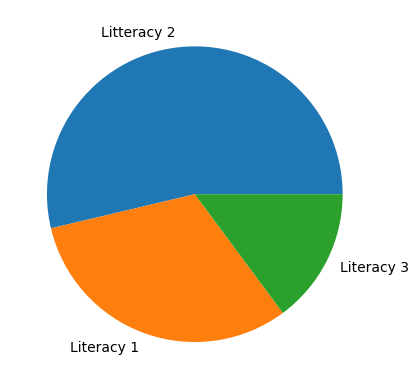

In [5]:
df_value_counts = df['LITERACY_3CLUSTERS'].value_counts()
ax = df_value_counts.plot(kind='pie', labels=['Litteracy 2', 'Literacy 1', 'Literacy 3'])
ax.set_ylabel('')

plt.savefig(r"..\Results\pie_graph_unbalancced_dataset.pdf", format="pdf", bbox_inches="tight")
plt.show()

We change the names of some columns. This happened to support the workflow of our paper. Also we group our features to 3 groups. The group A, group B and group C.

In [6]:
# GROUP A
df.rename(columns={'PERCENT_NONVOCAL': 'NVOC'}, inplace=True)
df.rename(columns={'PERCENT_VOCAL': 'VOC'}, inplace=True)
df.rename(columns={'PERCENT_COMPR': 'COMPR'}, inplace=True)
df.rename(columns={'PERCENT_VOCAB': 'VOCAB'}, inplace=True)
df.rename(columns={'PERCENT_MORPHOL': 'MOR'}, inplace=True)
df.rename(columns={'PERCENT_SYNTAX': 'SYNT'}, inplace=True)

# GROUP B
df.rename(columns={'TOTAL_HLE': 'HLE'}, inplace=True)
df.rename(columns={'TOTAL_ISBR': 'ISBR'}, inplace=True)
df.rename(columns={'EDUCATION_1': 'EDU_M'}, inplace=True)
df.rename(columns={'HOURSMOTHER': 'HRS_M'}, inplace=True)
df.rename(columns={'hoursworkmother': 'HRSWORK_M'}, inplace=True)
df.rename(columns={'WORKSTATUS_1': 'WSTATUS_M'}, inplace=True)
df.rename(columns={'NR_CHILDREN': 'NRCHILD'}, inplace=True)
df.rename(columns={'URBANITY': 'URB'}, inplace=True)
df.rename(columns={'NRBOOKS': 'NRBOOKS'}, inplace=True)
df.rename(columns={'ECONOMIC': 'ECONOMIC'}, inplace=True)
df.rename(columns={'EDUCATION_2': 'EDU_F'}, inplace=True)
df.rename(columns={'HOURSFATHER': 'HRS_F'}, inplace=True)
df.rename(columns={'hoursworkfather': 'HRSWORK_F'}, inplace=True)
df.rename(columns={'WORKSTATUS_2': 'WSTATUS_F'}, inplace=True)
df.rename(columns={'BIRTHORDER': 'BIRTHORDER'}, inplace=True)

# GROUP C
df.rename(columns={'GENDER': 'SEX'}, inplace=True)
df.rename(columns={'BIRTHWEIGHT': 'BIRTHWEIGHT'}, inplace=True)
df.rename(columns={'PREMAWEEK': 'GESTWEEK'}, inplace=True)

In [7]:
group_A = ['NVOC', 'VOC', 'COMPR', 'VOCAB', 'MOR', 'SYNT']
group_B = ['HLE', 'ISBR', 'EDU_M', 'HRS_M', 'HRSWORK_M', 'WSTATUS_M', 'NRCHILD', 'URB', 'NRBOOKS', 'ECONOMIC', 'EDU_F', 'HRS_F', 'HRSWORK_F', 'WSTATUS_F', 'BIRTHORDER']
group_C = ['BIRTHWEIGHT', 'GESTWEEK', 'SEX']

Define the columns from this dataset to use for the training. In each experiment we define a different subset of the Features. So change the next cell to choose different features.

In [8]:
# This is the subset that predicts the best results.
df = df[['AGE'] + group_A + ['HRS_M', 'HRS_F', 'HRSWORK_M'] + ['LITERACY_3CLUSTERS']] 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AGE                 229 non-null    int64 
 1   NVOC                229 non-null    int64 
 2   VOC                 229 non-null    int64 
 3   COMPR               229 non-null    int64 
 4   VOCAB               229 non-null    int64 
 5   MOR                 229 non-null    int64 
 6   SYNT                229 non-null    int64 
 7   HRS_M               229 non-null    object
 8   HRS_F               229 non-null    object
 9   HRSWORK_M           229 non-null    int64 
 10  LITERACY_3CLUSTERS  229 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 19.8+ KB
None


Use the pycaret to train and assess instantly 13 models. This give us the chance to see in each experiment the best model.

In [9]:
from pycaret.classification import *
from sklearn.metrics import classification_report

# Step 1: Setup / We se a session_id=123 which is the random seep to ensure that our experiments is reproducible
clf = setup(data=df, target='LITERACY_3CLUSTERS', train_size=0.75, session_id=123, verbose=False, normalize=True)

# Step 2: Train and pick best model
best_model = compare_models()

# Step 3: Evaluate on the holdout set (25% of data)
predictions = predict_model(best_model)

from sklearn.metrics import classification_report
print(classification_report(predictions['LITERACY_3CLUSTERS'], predictions['prediction_label']))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7363,0.7974,0.7363,0.7333,0.7195,0.5317,0.5468,0.0460
rf,Random Forest Classifier,0.6837,0.7873,0.6837,0.6562,0.6490,0.4173,0.4390,0.0560
knn,K Neighbors Classifier,0.6484,0.7519,0.6484,0.6149,0.6174,0.3804,0.3953,0.3940
dt,Decision Tree Classifier,0.6366,0.6924,0.6366,0.6520,0.6337,0.3739,0.3823,0.0170
lightgbm,Light Gradient Boosting Machine,0.5964,0.7284,0.5964,0.5805,0.5802,0.2943,0.3038,0.1630
ridge,Ridge Classifier,0.5961,0.0000,0.5961,0.5229,0.5501,0.2544,0.2663,0.0170
ada,Ada Boost Classifier,0.5735,0.0000,0.5735,0.5619,0.5556,0.2592,0.2687,0.0340
gbc,Gradient Boosting Classifier,0.5663,0.0000,0.5663,0.5447,0.5500,0.2539,0.2636,0.0700
lda,Linear Discriminant Analysis,0.5490,0.0000,0.5490,0.5216,0.5216,0.2087,0.2187,0.0170
lr,Logistic Regression,0.5428,0.0000,0.5428,0.5093,0.5202,0.1883,0.1932,0.5700


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.5345,0.6830,0.5345,0.4680,0.4968,0.1590,0.1631


              precision    recall  f1-score   support

           1       0.38      0.33      0.35        18
           2       0.66      0.81      0.72        31
           3       0.00      0.00      0.00         9

    accuracy                           0.53        58
   macro avg       0.34      0.38      0.36        58
weighted avg       0.47      0.53      0.50        58



Compute Partial Dependency Plot for Age

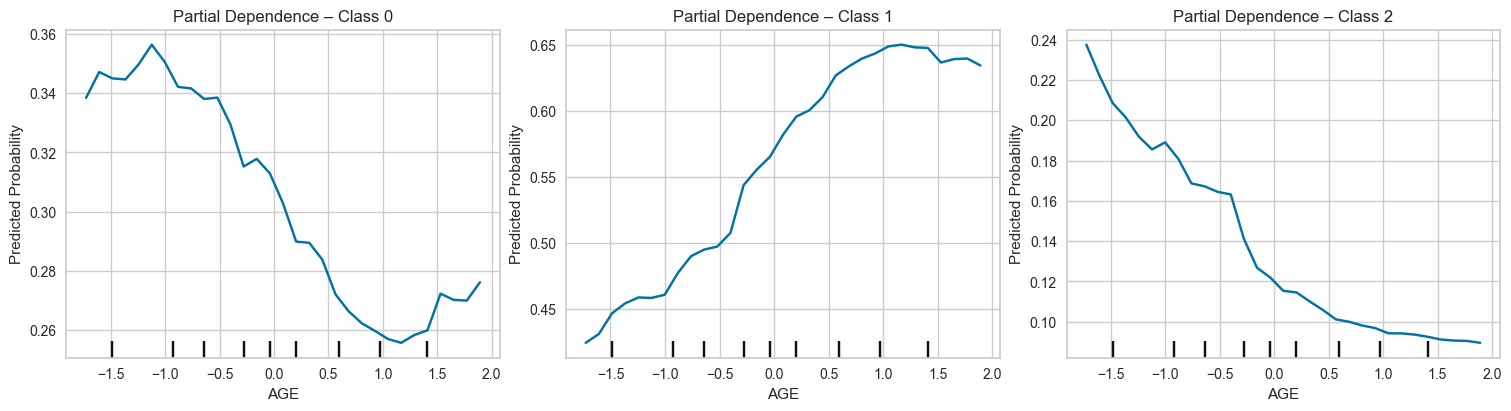

In [10]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Define number of classes and feature to plot
n_classes = 3
feature = "AGE"
class_labels = ["Class 0", "Class 1", "Class 2"]

# Get transformed training data
X_train_transformed = get_config('X_train_transformed')

# Create subplots
fig, axs = plt.subplots(1, n_classes, figsize=(5 * n_classes, 4), constrained_layout=True)

# Generate PDPs and add titles using display.axes_
for class_idx in range(n_classes):
    display = PartialDependenceDisplay.from_estimator(
        estimator=best_model,
        X=X_train_transformed,
        features=[feature],
        target=class_idx,
        grid_resolution=50,
        ax=axs[class_idx]
    )
    
    # Overwrite title using display.axes_
    display.axes_[0, 0].set_title(f"Partial Dependence – {class_labels[class_idx]}")
    display.axes_[0, 0].set_xlabel("AGE")
    display.axes_[0, 0].set_ylabel("Predicted Probability")

# Save to PDF
plt.savefig("..\Results\Partial_Dependence_AGE_T2_All_Classes.pdf", format="pdf", bbox_inches="tight")


Compute SHAP for Class 0 and visualize them.

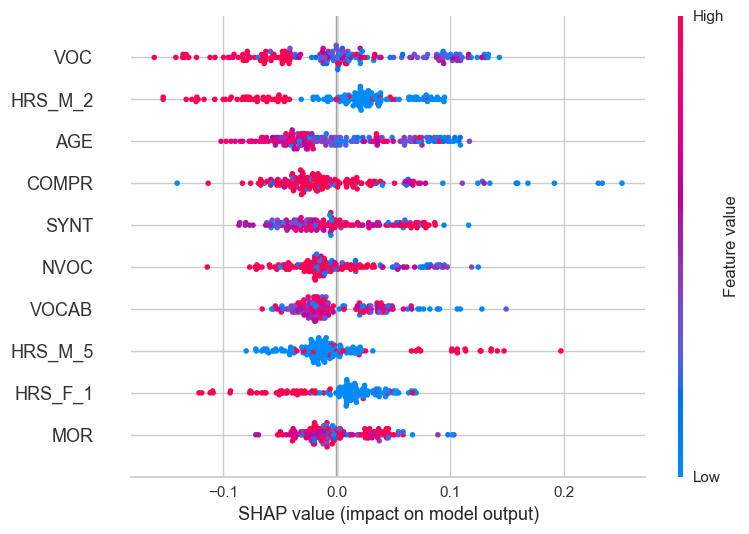

In [11]:
import shap
import matplotlib.pyplot as plt

max_display=10

# Get transformed training data
X_train_transformed = get_config('X_train_transformed')

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_transformed)

import numpy as np

# Convert the list into a single NumPy array
shap_values_array = np.stack(shap_values)  # Now should be (171, 22, 3)

# Choose a class index (e.g., class 1)
class_index = 0
shap_values_class = shap_values_array[:, :, class_index]  # (171, 22)

# Now plot
shap.summary_plot(shap_values_class, X_train_transformed, plot_type="dot", max_display=max_display, show=False)
# Grab the current figure and save
plt.savefig("..\Results\Shapley_Value_Best_Model_Class_0.pdf", format="pdf", bbox_inches="tight")


Compute SHAP for Class 1 and visualize them.

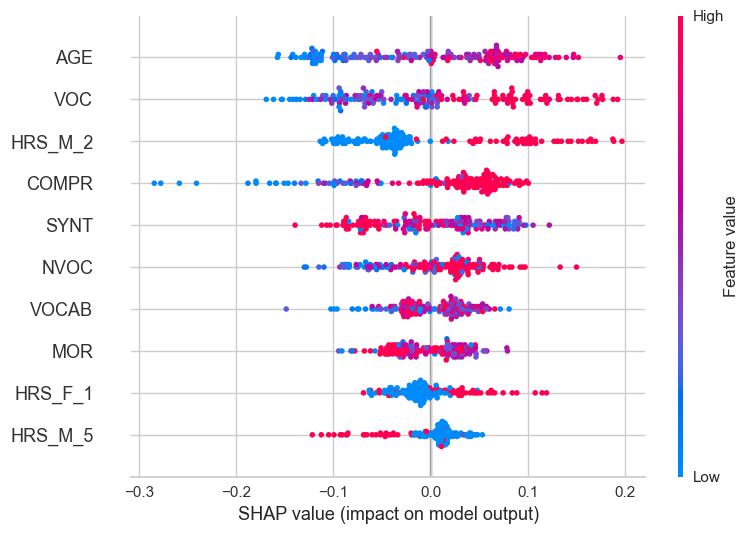

In [12]:
import shap
import matplotlib.pyplot as plt

max_display=10

# Get transformed training data
X_train_transformed = get_config('X_train_transformed')

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_transformed)

import numpy as np

# Convert the list into a single NumPy array
shap_values_array = np.stack(shap_values)  # Now should be (171, 22, 3)

# Choose a class index (e.g., class 1)
class_index = 1
shap_values_class = shap_values_array[:, :, class_index]  # (171, 22)

# Now plot
shap.summary_plot(shap_values_class, X_train_transformed, plot_type="dot", max_display=max_display, show=False)
# Grab the current figure and save
plt.savefig("..\Results\Shapley_Value_Best_Model_Class_1.pdf", format="pdf", bbox_inches="tight")


Compute SHAP for Class 2 and visualize them.

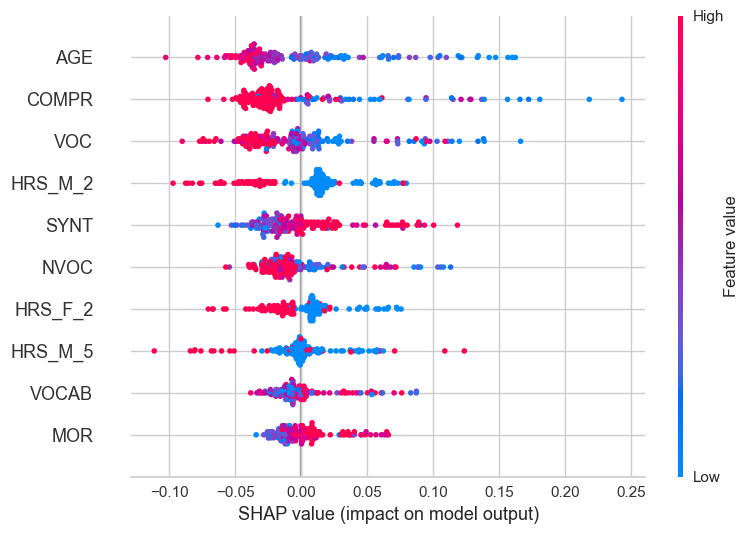

In [13]:
import shap
import matplotlib.pyplot as plt

max_display=10

# Get transformed training data
X_train_transformed = get_config('X_train_transformed')

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_transformed)

import numpy as np

# Convert the list into a single NumPy array
shap_values_array = np.stack(shap_values)  # Now should be (171, 22, 3)

# Choose a class index (e.g., class 1)
class_index = 2
shap_values_class = shap_values_array[:, :, class_index]  # (171, 22)

# Now plot
shap.summary_plot(shap_values_class, X_train_transformed, plot_type="dot", max_display=max_display, show=False)
# Grab the current figure and save
plt.savefig("..\Results\Shapley_Value_Best_Model_Class_2.pdf", format="pdf", bbox_inches="tight")
